# Workflow/Pipeline for GDP Nowcasting Using Google Trends Data & Extra Trees Regressor Regressor Model for Nigeria

| Step                   | Description                                                                                 |
|------------------------|---------------------------------------------------------------------------------------------|
| 1. Data Preparation    | Load and combine Google Trends and GDP data.                                               |
| 2. Preprocessing       | Convert monthly data to quarterly, normalize, detrend, and remove seasonality.             |
| 3. Feature Engineering | Calculate GDP growth rate and create lagged features & merge all features into a single DataFrame.                                   |
| 4. Train-Test Split    | Split data into training and testing sets while preserving time series order.              |
| 5. Model Training & Forecasting     | Train a Extra Trees regressor  model on the training data & perform rolling predictions on the test data and visualize                                             |                                    |
| 6. Visualize GDP Forecast | GDP reconstruction and visualize actual, fitted, and predicted GDP data.                                              |
|7. Hyperparameter Optimization with Cross Validation               | Using Grid Search and Cross Validation           |
|8. Model Evaluation | Evaluate the performance of the model using metrics  |
|9. Model Uncertainty Confidence Intervals | Bootstrapping |
|10. Visualization  | GDP Growth Rate and GDP  |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

## 1. Load Data

### 1.1 Load Google Trend Data 

In [2]:
gt_ng = pd.read_csv('data/nigeria/gt_2004-01-01_2024-12-16_NG.csv')

# convert date to datetime
gt_ng['date'] = pd.to_datetime(gt_ng['date'])

# convert the date into index 
gt_ng.set_index('date', inplace=True)

# display(gt_ng.head(2), gt_ng.tail(2))

### 1.2  Load Nigeria GDP data

In [3]:
gdp_na = pd.read_csv('data/nigeria/quarterly_realGDP_2010Q1_2024Q3_NG.csv', index_col=0)
gdp_na.index = pd.to_datetime(gdp_na.index)

# display(gdp_na.head(2), gdp_na.tail(2))
#  print('gdp_na shape:', gdp_na.shape)

### Visualize the GDP Data 

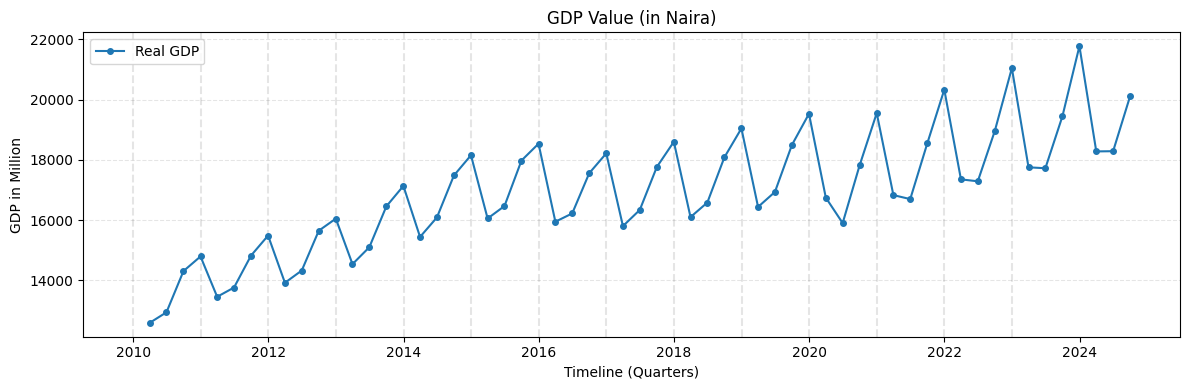

In [4]:
# Create a figure and a single subplot (axis) for plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Convert the index to datetime
plot_data = gdp_na['RealGDP']

plot_data.index = pd.to_datetime(plot_data.index)

# Set the major locator for the y-axis
# ax.yaxis.set_major_locator(plt.MultipleLocator(100000))

# Set the line style for the grid
ax.yaxis.grid(True, color='k', linestyle='--', alpha=0.1)

# Add vertical lines for each year
for year in range(2010,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.1)


# Plot the GDP Growth Rate
plt.plot(plot_data, marker='o', markersize=4, label="Real GDP")

# Set the title, x-axis label, and y-axis label
plt.gca().set(title="GDP Value (in Naira)", xlabel="Timeline (Quarters)", ylabel="GDP in Million")

# Set the x-ticks
plt.xticks()

# Add a legend
plt.legend(loc ='upper left')

# Set the layout
plt.tight_layout()

# Show the plot
plt.show()

## 2. Helper Functions

### 2.1 Convert Monthly Data to Quarterly

In [5]:
def get_gdp_data_quarterly(dataframe, match='0'): 
    # Input Validation: Ensures that the match parameter is one of the allowed values.
    if match not in ['0', '-1', '-2']:
        raise ValueError("Incorrect match value is passed !!")

    try:
        # Convert Index to Datetime: Ensures that the index of the dataframe is in datetime format.
        dataframe.index = pd.to_datetime(dataframe.index)

        # Filter the DataFrame for specific months (Quarterly default)
        same_month_data = dataframe[(dataframe.index.month == 4) |
                                    (dataframe.index.month == 7) |
                                    (dataframe.index.month == 10) |
                                    (dataframe.index.month == 1)]

        # Filter the DataFrame for previous month's quarters (-1 shift)
        one_month_back_data = dataframe[(dataframe.index.month == 3) |
                                        (dataframe.index.month == 6) |
                                        (dataframe.index.month == 9) |
                                        (dataframe.index.month == 12)]
        one_month_back_data.index = one_month_back_data.index - pd.DateOffset(months=0)  # Corrected shift

        # Filter the DataFrame for two months back quarters (-2 shift)
        two_months_back_data = dataframe[(dataframe.index.month == 2) |
                                         (dataframe.index.month == 5) |
                                         (dataframe.index.month == 8) |
                                         (dataframe.index.month == 11)]
        two_months_back_data.index = two_months_back_data.index - pd.DateOffset(months=1)  # Corrected shift

        if str(match) == '0':
            return same_month_data
        if str(match) == '-1':
            return one_month_back_data
        if str(match) == '-2':
            return two_months_back_data
    
    except Exception as e:
        print(f"Error: {e}")



In [6]:
quarterly_gt = get_gdp_data_quarterly(gt_ng, match='-1')
display(quarterly_gt.head(4), quarterly_gt.tail(4))

,Investment,government,USAID,BISP,parliament,Textile,subsidy,Birthday,Cars,mehngai,...,Cigarette,Real estate,House for sale,Economy News,Newspapers,CPI,Fitness,Hotels,Unemployment,stock market
date,,,,,,,,,,,,,,,,,,,,,
2010-03-31,45,64,44,0,12,10,0,20,32,0,...,0,33,0,0,100,0,30,55,66,32
2010-06-30,40,66,21,0,0,11,0,19,33,0,...,0,26,0,0,82,0,0,62,41,31
2010-09-30,27,51,18,0,0,12,0,19,26,0,...,0,17,9,0,68,0,24,37,37,22
2010-12-31,21,39,16,0,0,8,0,18,21,0,...,0,14,0,0,68,0,31,30,35,14


,Investment,government,USAID,BISP,parliament,Textile,subsidy,Birthday,Cars,mehngai,...,Cigarette,Real estate,House for sale,Economy News,Newspapers,CPI,Fitness,Hotels,Unemployment,stock market
date,,,,,,,,,,,,,,,,,,,,,
2024-03-31,16,58,3,0,4,3,1,67,8,0,...,51,13,7,31,5,78,33,18,16,5
2024-06-30,15,57,4,0,4,3,1,68,8,0,...,60,14,6,30,5,100,32,18,12,5
2024-09-30,32,53,3,0,3,4,1,57,7,0,...,59,13,5,19,5,74,39,16,9,4
2024-12-31,14,44,3,0,2,2,0,50,7,0,...,46,11,5,11,4,58,29,19,7,4


### 2.2 Normalize, Detrend, and Remove Seasonality

In [7]:
def normalize(dataframe):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(dataframe)
    return pd.DataFrame(scaled, index=dataframe.index, columns=dataframe.columns)

def detrend(dataframe):
    return dataframe.diff().dropna()

def remove_seasonality(dataframe):
    df = dataframe.copy()
    monthly_avg = df.groupby(df.index.month).mean()
    df_out = df - monthly_avg.loc[df.index.month].values
    return df_out

def make_predictors_df(*arg):
    "joins the predictors dataframes"
    if len(arg) > 1:
        for i in range(0, len(arg)-1):
            if i == 0:
                arg[i].index = pd.to_datetime(arg[i].index)
                arg[i+1].index = pd.to_datetime(arg[i+1].index)
                predictors_df = pd.merge(arg[i], arg[i+1], left_index=True, right_index=True)
            else:
                predictors_df = pd.merge(predictors_df, arg[i+1], left_index=True, right_index=True)
    else:
        arg[0].index = pd.to_datetime(arg[0].index)
        return arg[0]
    return predictors_df


In [8]:
scaled_gt_df = normalize(quarterly_gt)
detrended_gt = detrend(scaled_gt_df)
seasonality_gt = remove_seasonality(detrended_gt)
display(seasonality_gt.head(4), seasonality_gt.tail(4))

,Investment,government,USAID,BISP,parliament,Textile,subsidy,Birthday,Cars,mehngai,...,Cigarette,Real estate,House for sale,Economy News,Newspapers,CPI,Fitness,Hotels,Unemployment,stock market
date,,,,,,,,,,,,,,,,,,,,,
2010-06-30,-0.731765,0.284915,-3.009755,0.0,-5.587855,0.446482,-0.152770,-2.650704e-01,0.197741,0.0,...,-0.092551,-1.285399,-0.189227,0.111442,-0.711395,-0.031711,-3.242434,0.714541,-1.766751,-0.279663
2010-09-30,-1.032312,-0.791430,-0.424453,0.0,0.635744,0.148827,0.366647,8.614787e-02,-1.058497,0.0,...,0.068556,-1.664253,4.995603,-0.214085,-0.534272,0.031711,2.392233,-2.472312,0.149003,-1.085091
2010-12-31,-0.117605,-0.126629,-0.067527,0.0,0.267682,-0.863199,-0.244432,1.656690e-01,-0.663015,0.0,...,0.164535,-0.175897,-4.503612,0.219951,0.116146,0.063422,1.842102,-0.771704,0.207540,-1.085091
2011-03-31,0.399017,1.214279,0.702827,0.0,2.437815,0.924857,0.032736,-8.326673e-17,0.585746,0.0,...,-0.319521,1.565673,2.311277,-0.160250,0.233329,-0.232171,-1.044890,0.972286,0.632883,0.227725


,Investment,government,USAID,BISP,parliament,Textile,subsidy,Birthday,Cars,mehngai,...,Cigarette,Real estate,House for sale,Economy News,Newspapers,CPI,Fitness,Hotels,Unemployment,stock market
date,,,,,,,,,,,,,,,,,,,,,
2024-03-31,-0.189008,-7.801234e-01,-0.020671,0.0,-0.573604,3.189160e-02,0.032736,-0.049701,0.062313,0.0,...,-0.473772,-0.463903,0.040549,0.587582,0.015555,0.203857,-0.169683,-0.421069,-0.245171,-0.275667
2024-06-30,-0.339748,1.387779e-17,0.463039,0.0,0.434983,2.220446e-17,-0.152770,-0.165669,0.023264,0.0,...,0.370204,0.338263,-0.756910,0.067452,0.072591,0.840344,0.383424,-0.035727,-0.090466,-0.111865
2024-09-30,1.907817,2.532575e-01,-0.135053,0.0,0.133841,1.488275e-01,0.366647,-0.460560,-0.011632,0.0,...,0.017139,-0.040592,-0.681219,-0.697977,0.075495,-0.998900,0.266730,-0.007145,0.228826,0.257290
2024-12-31,-1.293657,1.582859e-01,0.221873,0.0,-0.234221,2.976550e-02,-0.702741,-0.132535,0.209373,0.0,...,-0.503888,0.027061,0.605528,-0.131970,0.072591,-0.570800,-0.283400,0.300107,0.207540,0.257290


## 3. Feature Engineering 

### 3.1 Calculate GDP Growth Rate

In [9]:

df_gdp_growth = gdp_na.copy()
df_gdp_growth['GDP_GrowthRate'] = df_gdp_growth['RealGDP'].pct_change()
df_gdp_growth = df_gdp_growth.drop('RealGDP', axis=1)
df_gdp_growth.dropna(inplace=True)

# Keep only the growth rate column
response_var = 'GDP_GrowthRate'
rg_response_var = df_gdp_growth[[response_var]]

display(rg_response_var.head(2), rg_response_var.tail(2))

,GDP_GrowthRate
date,
2010-06-30,0.027898
2010-09-30,0.105911


,GDP_GrowthRate
date,
2024-06-30,0.000373
2024-09-30,0.100123


### 3.2 Create a Lag-1 of GDP Growth

In [10]:

rg_response_var = rg_response_var.iloc[1:,:]
# Create a lagged version of the response variable (GDP_GrowthRate) by shifting the data by one row
lag1 = df_gdp_growth[[response_var]].iloc[0:df_gdp_growth.shape[0]-1,:]
# Align the index of the lagged DataFrame (lag1) with the index of the response variable DataFrame (rg_response_var)
lag1.index = rg_response_var.index
# Rename the column in the lagged DataFrame from 'GDP_GrowthRate' to 'lag1'
lag1 = lag1.rename(columns={response_var: 'lag1'})

display(lag1.head(3), lag1.head(2))

,lag1
date,
2010-09-30,0.027898
2010-12-31,0.105911
2011-03-31,0.033932


,lag1
date,
2010-09-30,0.027898
2010-12-31,0.105911


In [11]:
# Make sure the predictors and response variable indices are date time
lag1.index = pd.to_datetime(lag1.index)
detrended_gt.index = pd.to_datetime(detrended_gt.index)

### 3.3 Merge Predictors

In [12]:
def make_predictors_df(*arg):
    "joins the predictors dataframes"
    if len(arg) > 1:
        for i in range(0, len(arg)-1):
            if i == 0:
                arg[i].index = pd.to_datetime(arg[i].index)
                arg[i+1].index = pd.to_datetime(arg[i+1].index)
                predictors_df = pd.merge(arg[i], arg[i+1], left_index=True, right_index=True)
            else:
                predictors_df = pd.merge(predictors_df, arg[i+1], left_index=True, right_index=True)
    else:
        arg[0].index = pd.to_datetime(arg[0].index)
        return arg[0]
    return predictors_df

In [13]:
# (5) Merge all GT predictors
predictors_gt = make_predictors_df(lag1, detrended_gt)
display(predictors_gt.head(2), predictors_gt.tail(2))

,lag1,Investment,government,USAID,BISP,parliament,Textile,subsidy,Birthday,Cars,...,Cigarette,Real estate,House for sale,Economy News,Newspapers,CPI,Fitness,Hotels,Unemployment,stock market
date,,,,,,,,,,,,,,,,,,,,,
2010-09-30,0.027898,-1.274056,-1.424573,-0.434099,0.0,0.0,0.446482,0.0,0.000000,-1.221343,...,0.0,-1.826619,5.109139,0.0,-0.609767,0.0,3.000710,-2.679529,-0.319292,-1.510178
2010-12-31,0.105911,-0.588026,-1.139659,-0.289400,0.0,0.0,-1.785930,0.0,-0.049701,-0.872388,...,0.0,-0.608873,-5.109139,0.0,0.000000,0.0,0.875207,-0.750268,-0.159646,-1.342380


,lag1,Investment,government,USAID,BISP,parliament,Textile,subsidy,Birthday,Cars,...,Cigarette,Real estate,House for sale,Economy News,Newspapers,CPI,Fitness,Hotels,Unemployment,stock market
date,,,,,,,,,,,,,,,,,,,,,
2024-06-30,-0.160520,-0.098004,-0.094972,0.1447,0.0,0.000000,0.000000,0.0,0.049701,0.000000,...,0.462754,0.202958,-0.567682,-0.043990,0.0,0.872055,-0.125030,0.000000,-0.319292,0.000000
2024-09-30,0.000373,1.666073,-0.379886,-0.1447,0.0,-0.501903,0.446482,0.0,-0.546708,-0.174478,...,-0.051417,-0.202958,-0.567682,-0.483891,0.0,-1.030611,0.875207,-0.214362,-0.239469,-0.167798


### 4. Train-Test Split

In [14]:
def ts_train_test_split(response_df, predictors_df, test_size=0.2):
    """
    Merge response & predictors, time-based split.
    """
    joined_df = pd.merge(response_df, predictors_df, left_index=True, right_index=True, how='inner')
    joined_df.sort_index(inplace=True)

    if test_size <= 0:
        return joined_df, pd.DataFrame(), pd.DataFrame()

    n = len(joined_df)
    test_len = int(round(n * test_size))
    train = joined_df.iloc[:-test_len, :]
    test = joined_df.iloc[-test_len:, :]

    last_date = joined_df.index[-1]
    extra_test_data = predictors_df.loc[predictors_df.index > last_date]
    return train, test, extra_test_data

In [15]:
# Train/Test split
train, test, extra_test = ts_train_test_split(rg_response_var, predictors_gt, test_size=0.2)

print("Train shape:", train.shape)
print("Test shape :", test.shape)

Train shape: (46, 59)
Test shape : (11, 59)


### Plot the GDP Growth Rate

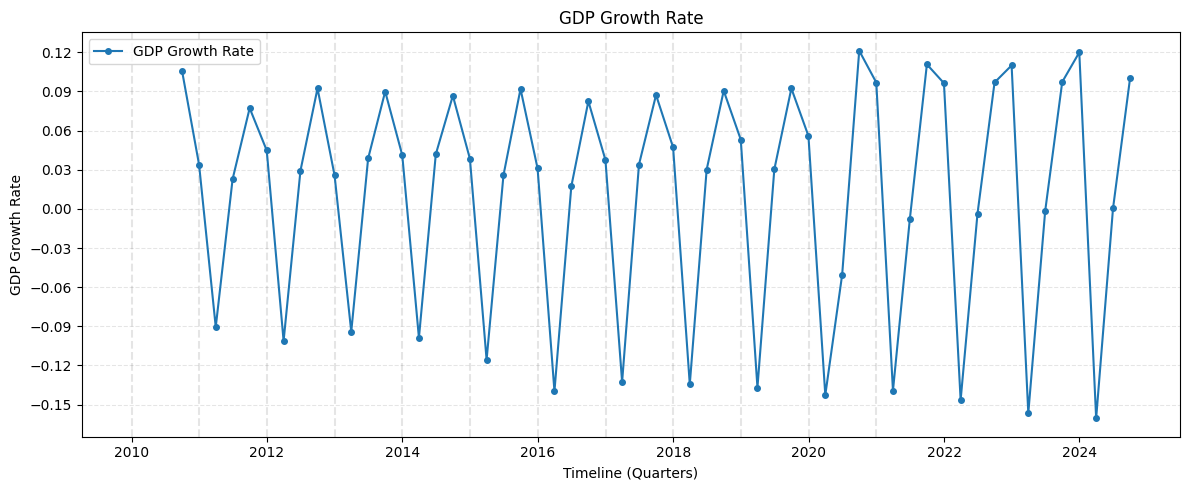

In [16]:
# Plot the GDP Growth Rate
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Convert the index to datetime
rg_response_var.index = pd.to_datetime(rg_response_var.index)

# Set the major locator for the y-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(0.03))

# Set the line style for the grid
ax.yaxis.grid(True, color='k', linestyle='--', alpha=0.1)

# Add vertical lines for each year
for year in range(2010,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.1)


# Plot the GDP Growth Rate
plt.plot(rg_response_var, marker='o', markersize=4, label="GDP Growth Rate")

# Set the title, x-axis label, and y-axis label
plt.gca().set(title="GDP Growth Rate", xlabel="Timeline (Quarters)", ylabel="GDP Growth Rate")

# Set the x-ticks
plt.xticks()

# Add a legend
plt.legend(loc ='upper left')

# Set the layout
plt.tight_layout()

# Show the plot
plt.show()

## 5. Model Training: Extra Trees Regressor

### 5A. Train on the training set

In [17]:
def et_modelfit(train_df,
               response_var='GDP_GrowthRate',
               n_estimators=100,
               max_depth=None,
               random_state=42):
    """
    Fit an ExtraTreesRegressor on the training data.
    """
    X = train_df.drop(columns=[response_var])
    y = train_df[response_var].values.ravel()

    model = ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )
    model.fit(X, y)
    return model

In [18]:
# A. Train on the training set
X_train = train.drop(columns=[response_var])
y_train = train[response_var]

# Fit the ET model once on the entire training set
et_model = et_modelfit(train, response_var=response_var, n_estimators=100,  max_depth=None, random_state=42)

# Predict in-sample (training)
fitted_train_vals = et_model.predict(X_train)
fitted_train_vals = pd.DataFrame(
    fitted_train_vals,
    index=train.index,
    columns=['Fitted_Train']
)

### 5B. Rolling forecast using Extra Trees Regressor

In [19]:
def rolling_prediction_et(train_df, 
                         test_df,
                         dependent_var='GDP_GrowthRate',
                         n_estimators=100,
                         max_depth=None,
                         random_state=42):
    """
    Rolling forecast with Extra Trees:
      1) Fit on current `train_df`
      2) Predict first row of `test_df`
      3) Append that row (with actual y) to `train_df`
      4) Drop that row from `test_df`
      5) Repeat
    """
    test_copy = test_df.copy()
    predictions = []

    if test_df.empty:
        return pd.DataFrame(index=test_df.index, columns=['Predicted_Value'])

    for _ in range(len(test_df)):
        # Fit model on current train
        model = et_modelfit(
            train_df,
            response_var=dependent_var,
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state
        )

        # Predict the first row of test
        firstrow = test_df.iloc[[0]]
        X_test_row = firstrow.drop(columns=[dependent_var])
        y_pred = model.predict(X_test_row)[0]

        # Collect prediction
        predictions.append(y_pred)

        # Walk-forward => move row from test to train
        train_df = pd.concat([train_df, firstrow])
        test_df = test_df.iloc[1:]

        if test_df.empty:
            break

    pred_series = pd.Series(predictions, index=test_copy.index, name='Predicted_Value')
    return pred_series.to_frame()

In [20]:
# Rolling predictions on test
et_pred_test = rolling_prediction_et(
    train.copy(),
    test.copy(),
    dependent_var='GDP_GrowthRate',
    n_estimators=100,
    max_depth=None,
    random_state=42
)

et_pred_test = pd.DataFrame({'Predicted_Test': et_pred_test.squeeze()})

# Combine
results = pd.DataFrame({
    'GDP_GrowthRate': rg_response_var['GDP_GrowthRate'],
    'Fitted Value': fitted_train_vals.squeeze(),
    'Predicted Value': et_pred_test.squeeze()
})
results.head()

,GDP_GrowthRate,Fitted Value,Predicted Value
date,,,
2010-09-30,0.105911,0.105911,NaN
2010-12-31,0.033932,0.033932,NaN
2011-03-31,-0.090542,-0.090542,NaN
2011-06-30,0.022825,0.022825,NaN
2011-09-30,0.077185,0.077185,NaN


### 5C. Plot: Actual vs. Fitted & Predicted Growth Rate

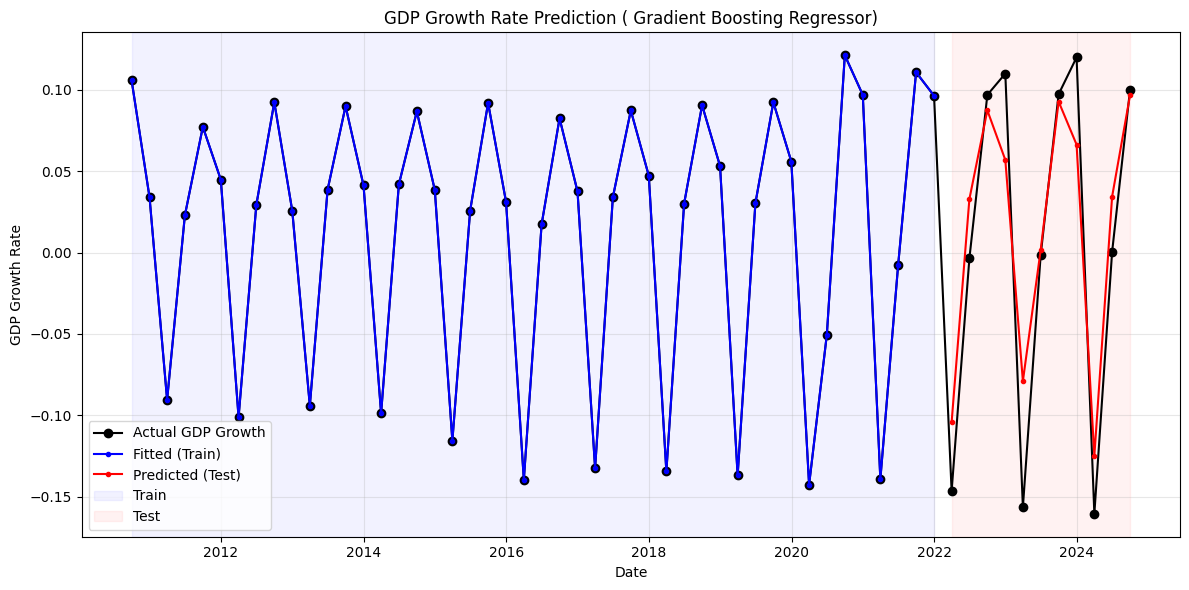

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['GDP_GrowthRate'], 'ko-', label='Actual GDP Growth')
plt.plot(results.index, results['Fitted Value'], 'b.-', label='Fitted (Train)')
plt.plot(results.index, results['Predicted Value'], 'r.-', label='Predicted (Test)')

# Highlight train/test
if not train.empty:
    plt.axvspan(train.index.min(), train.index.max(), color='blue', alpha=0.05, label='Train')
if not test.empty:
    plt.axvspan(test.index.min(), test.index.max(), color='red', alpha=0.05, label='Test')

plt.title("GDP Growth Rate Prediction ( Gradient Boosting Regressor)")
plt.xlabel("Date")
plt.ylabel("GDP Growth Rate")
plt.legend(loc ='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Visualize GDP Forecast

### GDP Reconstruction

In [22]:
base_GDP = gdp_na['RealGDP'].iloc[1]

X_svr = train.loc[:, ~train.columns.isin(['GDP_GrowthRate'])]
    
fitted_values = et_model.predict(X_svr)  
    
    
fitted_values = pd.DataFrame(fitted_values, columns=['Fitted GDP_GrowthRate'])
    
fitted_values.index = train.index

fitted_GDP = [0]*(len(fitted_values)+1)

fitted_GDP[0] = base_GDP

for i, value in enumerate(fitted_values['Fitted GDP_GrowthRate']):
    fitted_GDP[i+1] = fitted_GDP[i]*(1 + value)
fitted_GDP_df = pd.DataFrame(fitted_GDP[1:])
fitted_GDP_df.index = train.index

gdp_na.index = pd.to_datetime(gdp_na.index)
train.index = pd.to_datetime(train.index)

fitted_GDP = [0]*(len(fitted_values)+1)

fitted_GDP[0] = base_GDP

for i, value in enumerate(fitted_values['Fitted GDP_GrowthRate']):
    fitted_GDP[i+1] = fitted_GDP[i]*(1 + value)
fitted_GDP_df = pd.DataFrame(fitted_GDP[1:])
fitted_GDP_df.index = train.index

base_GDP_test = gdp_na[gdp_na.index == train.index[-1]]['RealGDP'].iloc[0]

pred_gdpGrowth = et_pred_test
predicted_GDP = [0]*pred_gdpGrowth.shape[0]
actual_GDP = base_GDP_test


if not test.empty:
    for i in range(0, test.shape[0]):
        value = pred_gdpGrowth.iloc[i,0]

        predicted_GDP[i] = actual_GDP*(1 + value)
      
        actual_GDP = gdp_na.loc[test.index[i]].iloc[0]

        predicted_GDP_df = pd.DataFrame(predicted_GDP)
        predicted_GDP_df.index = pred_gdpGrowth.index
        predicted_GDP_df = pd.concat([gdp_na[gdp_na.index == train.index[-1]]['RealGDP'], predicted_GDP_df])
        predicted_GDP_df = predicted_GDP_df.rename(columns={0: 'GDP_Predicted'})

display(predicted_GDP_df.head(2), predicted_GDP_df.tail(2))

,RealGDP,GDP_Predicted
date,,
2021-12-31,20329.06,NaN
2022-03-31,NaN,18209.881458


,RealGDP,GDP_Predicted
date,,
2024-06-30,NaN,18905.816833
2024-09-30,NaN,20054.045548


In [23]:
# Combine actual and predicted GDP values
Actual_GDP = gdp_na['RealGDP'][1:]
fittedandActual_GDP = pd.DataFrame({'Actual GDP': Actual_GDP,
                                    'Fitted GDP': fitted_GDP_df.squeeze(),
                                    'Predicted GDP': predicted_GDP_df['GDP_Predicted'].squeeze()
                                    })

fittedandActual_GDP = fittedandActual_GDP.iloc[1:]

display(fittedandActual_GDP.head(2), fittedandActual_GDP.tail(2))

,Actual GDP,Fitted GDP,Predicted GDP
date,,,
2010-09-30,14304.44,14304.44,NaN
2010-12-31,14789.82,14789.82,NaN


,Actual GDP,Fitted GDP,Predicted GDP
date,,,
2024-06-30,18285.02,NaN,18905.816833
2024-09-30,20115.77,NaN,20054.045548


### Evaluate on the Test Set (R² Score)

In [24]:
# The test set's actual GDP growth
y_test = test['GDP_GrowthRate']

# The predicted values in knn_pred_test DataFrame
y_pred = et_pred_test['Predicted_Test']
    
# Merge so we only compare the overlapping index
test_merge = pd.merge(y_test, y_pred, left_index=True, right_index=True, how='inner')

# Compute R²
r2 = r2_score(test_merge['GDP_GrowthRate'], test_merge['Predicted_Test'])
print(f" R² score on the test set: {r2:.2f}")

 R² score on the test set: 0.86


### Plot the fitted and Actual GDP 

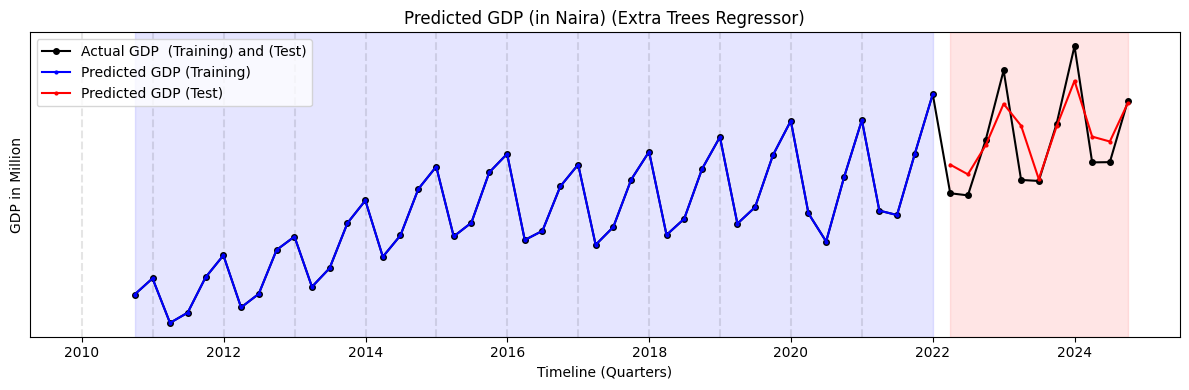

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4)) 

# Convert the index to datetime
fittedandActual_GDP.index = pd.to_datetime(fittedandActual_GDP.index)  

# Set the major locator for the y-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(100000))

# Set the line style for the grid
ax.yaxis.grid(True, color='k', linestyle='--', alpha=0.1)

# Add vertical lines for each year
for year in range(2010,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.1)


# Plot the GDP Growth Rate
plt.plot(fittedandActual_GDP['Actual GDP'], 'ko-', markersize=4, label="Actual GDP  (Training) and (Test)")

plt.plot(fittedandActual_GDP['Fitted GDP'], 'b.-', markersize=4, label="Predicted GDP (Training)")

plt.plot(fittedandActual_GDP['Predicted GDP'], 'r.-', markersize=4, label="Predicted GDP (Test)")


# Highlight training region
plt.axvspan(train.index.min(), train.index.max(), color='blue', alpha=0.1)


# Highlight test region
plt.axvspan(test.index.min(), test.index.max(), color='red', alpha=0.1)


# Set the title, x-axis label, and y-axis label
plt.gca().set(title="Predicted GDP (in Naira) (Extra Trees Regressor)",
               xlabel="Timeline (Quarters)", 
               ylabel="GDP in Million")

# Set the x-ticks
plt.xticks()

# Add a legend
plt.legend(loc ='upper left')

# Set the layout
plt.tight_layout()

# Show the plot
plt.show()

## 7. Hyperparameter Tunning and Cross Validation 

In [26]:
param_grid = {
    'n_estimators':     [50, 100, 200],
    'criterion':        ['squared_error', 'friedman_mse'],  # or 'absolute_error' if you prefer
    'max_depth':        [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features':      [None, 'sqrt', 'log2'],
    'bootstrap':         [False, True]
}

model = ExtraTreesRegressor()


# Set up GridSearchCV 

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # or 'r2'
    cv=5,              # 5-fold cross validation
    n_jobs=-1,         # use all CPU cores
    verbose=1          # print progress messages

)


# Fit the search on the training set
grid_search.fit(X_train, y_train)

# Retrieve the best model and check its params
best_et = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)
print("Best (negative) MSE Score from CV:", grid_search.best_score_)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Params: {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best (negative) MSE Score from CV: -0.001172907185849841


## Evaluatation

###  Evaluate on the training Set

In [27]:
# In-sample predictions for training
y_pred_train = best_et.predict(X_train)

In [28]:
# Evaluate training if desired
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train  = r2_score(y_train, y_pred_train)
print(f"In-sample MSE: {mse_train:.3f}, R²: {r2_train:.3f}")


In-sample MSE: 0.000, R²: 1.000


###  Evaluate on the Test Set

In [29]:
y_test = test['GDP_GrowthRate']
X_test = test.drop('GDP_GrowthRate', axis=1)


y_pred_baseline = best_et.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_baseline)
r2_test = r2_score(y_test, y_pred_baseline)

print(f"Test MSE: {mse_test:.3f}")
print(f"Test R²:  {r2_test:.3f}")


Test MSE: 0.002
Test R²:  0.856


## 8. Model Uncertainty Confidence Intervals

In [30]:
# Bootstrapping to get confidence intervals
n_bootstraps = 100  # e.g., 100 or 500, or more for a smoother estimate

predictions_boot = np.zeros((X_test.shape[0], n_bootstraps))

for i in range(n_bootstraps):
    # a) Resample training data (same size as original, with replacement)
    X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
    
    # b) Fit a Lasso with the same hyperparams as best_lasso
    boot_model = ExtraTreesRegressor(
        n_estimators=best_et.n_estimators, 
        criterion=best_et.criterion,
        max_depth = best_et.max_depth, 
        min_samples_split = best_et.min_samples_split,
        min_samples_leaf = best_et.min_samples_leaf,
        max_features = best_et.max_features,
        bootstrap = best_et.bootstrap,

        )
    
    boot_model.fit(X_resampled, y_resampled)

    # c) Predict on X_test
    y_pred_boot = boot_model.predict(X_test)

    # d) Store predictions
    predictions_boot[:, i] = y_pred_boot

# Compute 5th and 95th percentiles (or 2.5 and 97.5 if you want 95% intervals)
lower_q = 5
upper_q = 95

y_pred_lower = np.percentile(predictions_boot, lower_q, axis=1)
y_pred_upper = np.percentile(predictions_boot, upper_q, axis=1)

### Combine into a DataFrame for convenience


In [31]:
df_test_results = pd.DataFrame({
    'Actual': y_test,
    'Pred_Baseline': y_pred_baseline,
    'Pred_Lower': y_pred_lower,
    'Pred_Upper': y_pred_upper
}, index=y_test.index)


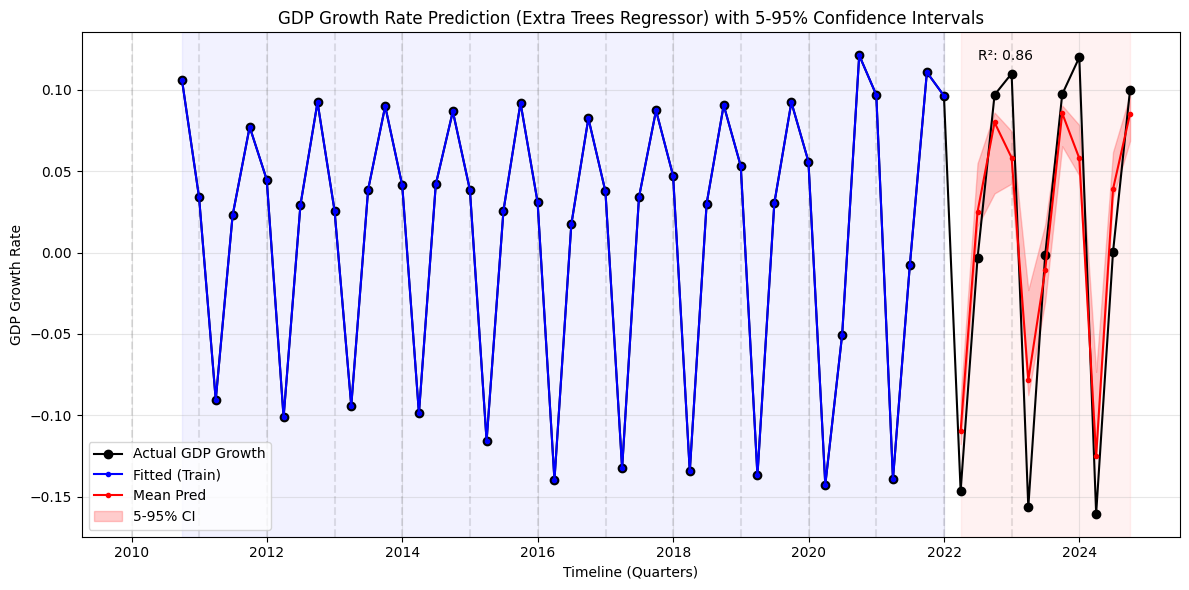

In [32]:
plt.figure(figsize=(12, 6))

# Set the major locator for the y-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# Set the line style for the grid
ax.yaxis.grid(True, color='k', linestyle='--', alpha=0.1)

# Add vertical lines for each year
for year in range(2010,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.1)


plt.plot(results.index, results['GDP_GrowthRate'], 'ko-', label='Actual GDP Growth')
plt.plot(results.index, results['Fitted Value'], 'b.-', label='Fitted (Train)')
plt.plot(df_test_results.index, df_test_results['Pred_Baseline'], 'r.-', label='Mean Pred')


plt.fill_between(
    df_test_results.index, 
    df_test_results['Pred_Lower'], 
    df_test_results['Pred_Upper'], 
    color='red', alpha=0.2, label='5-95% CI'
)


# Highlight train/test
if not train.empty:
    plt.axvspan(train.index.min(), train.index.max(), color='blue', alpha=0.05)
if not test.empty:
    plt.axvspan(test.index.min(), test.index.max(), color='red', alpha=0.05)



# Set the title, x-axis label, and y-axis label
plt.gca().set(title="GDP Growth Rate Prediction (Extra Trees Regressor) with 5-95% Confidence Intervals",
               xlabel="Timeline (Quarters)", 
               ylabel="GDP Growth Rate")
plt.xticks()
plt.legend(loc ='best')

plt.text(0.82, 1.55, f'R²: {r2_test:.2f}', transform=ax.transAxes)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### GDP Reconstruction

In [33]:
train_end_date = train.index[-1]
base_GDP_test = gdp_na.loc[train_end_date, 'RealGDP']  

# Make sure df_test_results is sorted by date
df_test_results = df_test_results.sort_index()

# Create columns for level reconstruction
df_test_results['GDP_Level_Baseline'] = np.nan
df_test_results['GDP_Level_Lower']    = np.nan
df_test_results['GDP_Level_Upper']    = np.nan

# Reconstruct levels from the predicted growth rates
previous_level_baseline = base_GDP_test
previous_level_lower    = base_GDP_test
previous_level_upper    = base_GDP_test

for i, date in enumerate(df_test_results.index):
    # Predicted growth rates (e.g. 0.01 => 1% growth)
    g_baseline = df_test_results.loc[date, 'Pred_Baseline']
    g_lower    = df_test_results.loc[date, 'Pred_Lower']
    g_upper    = df_test_results.loc[date, 'Pred_Upper']

    # Reconstruct level for Baseline
    current_level_baseline = previous_level_baseline * (1.0 + g_baseline)
    df_test_results.loc[date, 'GDP_Level_Baseline'] = current_level_baseline

    # Reconstruct level for Lower
    current_level_lower = previous_level_lower * (1.0 + g_lower)
    df_test_results.loc[date, 'GDP_Level_Lower'] = current_level_lower

    # Reconstruct level for Upper
    current_level_upper = previous_level_upper * (1.0 + g_upper)
    df_test_results.loc[date, 'GDP_Level_Upper'] = current_level_upper

    # Update "previous" for the next iteration
    previous_level_baseline = current_level_baseline
    previous_level_lower    = current_level_lower
    previous_level_upper    = current_level_upper

### Plot the Fitted and Actual GDP 

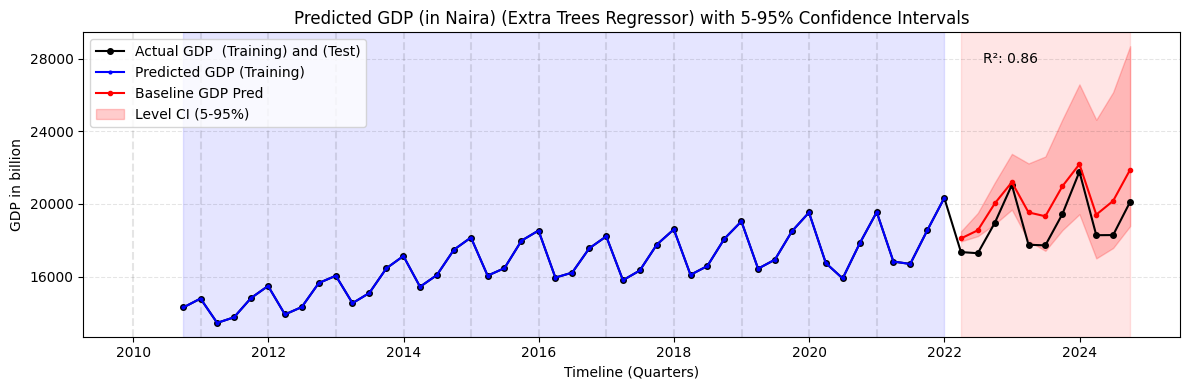

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4)) 

# Convert the index to datetime
fittedandActual_GDP.index = pd.to_datetime(fittedandActual_GDP.index)  

# Set the major locator for the y-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(4000))

# Set the line style for the grid
ax.yaxis.grid(True, color='k', linestyle='--', alpha=0.1)

# Add vertical lines for each year
for year in range(2010,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.1)


# Plot the GDP Growth Rate
plt.plot(fittedandActual_GDP['Actual GDP'], 'ko-', markersize=4, label="Actual GDP  (Training) and (Test)")

plt.plot(fittedandActual_GDP['Fitted GDP'], 'b.-', markersize=4, label="Predicted GDP (Training)")


# Plot Baseline level
plt.plot(df_test_results.index, df_test_results['GDP_Level_Baseline'], 'r.-', label='Baseline GDP Pred')

# Fill between Lower and Upper
plt.fill_between(
    df_test_results.index, 
    df_test_results['GDP_Level_Lower'], 
    df_test_results['GDP_Level_Upper'],
    color='red', alpha=0.2, label='Level CI (5-95%)'
)


# Highlight training region
plt.axvspan(train.index.min(), train.index.max(), color='blue', alpha=0.1)


# Highlight test region
plt.axvspan(test.index.min(), test.index.max(), color='red', alpha=0.1)


# Set the title, x-axis label, and y-axis label
plt.gca().set(title="Predicted GDP (in Naira) (Extra Trees Regressor) with 5-95% Confidence Intervals",
               xlabel="Timeline (Quarters)", 
               ylabel="GDP in billion")

# Set the x-ticks
plt.xticks()

# Add a legend
plt.legend(loc ='upper left')

plt.text(0.82, 0.9, f'R²: {r2_test:.2f}', transform=ax.transAxes)

# Set the layout
plt.tight_layout()

# Show the plot
plt.show()